In [1]:
""" Python main script of MatMat trade module

    Notes
    ------
    Fill notes if necessary

    """

' Python main script of MatMat trade module\n\n    Notes\n    ------\n    Fill notes if necessary\n\n    '

# Imports

In [2]:
# general
import sys
import os
import copy

# scientific
import numpy as np
import pandas as pd
import pymrio
import matplotlib.pyplot as plt

# local folder
from local_paths import data_dir
from local_paths import output_dir

# local library
from utils import Tools

# SETTINGS

In [3]:
# year to study in [*range(1995, 2022 + 1)]
base_year = 2015

# system type: pxp or ixi
system = 'pxp'

# agg name: to implement in agg_matrix.xlsx
agg_name = {
	'sector': 'ref',
	'region': 'ref'
}

# define filename concatenating settings
concat_settings = str(base_year) + '_' + \
	agg_name['sector']  + '_' +  \
	agg_name['region']

# set if rebuilding calibration from exiobase
calib = False

# READ/ORGANIZE/CLEAN DATA

In [4]:
# define file name
file_name = 'IOT_' + str(base_year) + '_' + system + '.zip'


# download data online
if not os.path.isfile(data_dir / file_name):

	pymrio.download_exiobase3(
	    storage_folder = data_dir,
	    system = system, 
	    years = base_year
	)


# import or build calibration data
if calib:

	# import exiobase data
	reference = pymrio.parse_exiobase3(
		data_dir / file_name
	)

	# isolate ghg emissions
	reference.ghg_emissions = Tools.extract_ghg_emissions(reference)

	# del useless extensions
	reference.remove_extension(['satellite', 'impacts'])

	# import agregation matrices
	agg_matrix = {
		key: pd.read_excel(
			data_dir / 'agg_matrix.xlsx',
			sheet_name = key + '_' + value
		) for (key, value) in agg_name.items()
	}
	agg_matrix['sector'].set_index(['category', 'sub_category', 'sector'], inplace = True)
	agg_matrix['region'].set_index(['Country name', 'Country code'], inplace = True)

	# apply regional and sectorial agregations
	reference.aggregate(
		region_agg = agg_matrix['region'].T.values,
		sector_agg = agg_matrix['sector'].T.values,
		region_names = agg_matrix['region'].columns.tolist(),
		sector_names = agg_matrix['sector'].columns.tolist()
	)

	# reset all to flows before saving
	reference = reference.reset_to_flows()
	reference.ghg_emissions.reset_to_flows()

	# save calibration data
	reference.save_all(
		data_dir / ('reference' + '_' + concat_settings)
	)

else:

	# import calibration data built with calib = True
	reference = pymrio.parse_exiobase3(
		data_dir / ('reference' + '_' + concat_settings)
	)


# CALCULATIONS

In [5]:
# calculate reference system
reference.calc_all()


# update extension calculations
reference.ghg_emissions_desag = Tools.recal_extensions_per_region(
	reference,
	'ghg_emissions'
)

# init counterfactual(s)
counterfactual = reference.copy()
counterfactual.remove_extension('ghg_emissions_desag')


# read param sets to shock reference system
## ToDo


# build conterfactual(s) using param sets
## ToDo


# calculate counterfactual(s) system
counterfactual.calc_all()
counterfactual.ghg_emissions_desag = Tools.recal_extensions_per_region(
	counterfactual,
	'ghg_emissions'
)

/home/theom/Bureau/Ubuntu_SSD/miniconda3/lib/python3.9/site-packages/pymrio/core/mriosystem.py:878: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  Y_agg = Y.sum(level="region", axis=1).reindex(
/home/theom/Bureau/Ubuntu_SSD/miniconda3/lib/python3.9/site-packages/pymrio/core/mriosystem.py:928: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  F_Y_agg = self.F_Y.sum(level="region", axis=1).reindex(
/home/theom/Bureau/Ubuntu_SSD/miniconda3/lib/python3.9/site-packages/pymrio/core/mriosystem.py:960: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df

# FORMAT RESULTS

region                         FR                                             \
sector                Agriculture    Crude coal      Crude oil   Natural gas   
region     stressor                                                            
FR         CO2       4.791573e+09  1.381993e+07   31372.122054  2.894399e+09   
Europe     CO2       2.018949e+09  4.434783e+05   20892.829814  2.825042e+08   
BRICS      CO2       9.562949e+08  3.335106e+06   74307.337396  3.012630e+08   
Other_OECD CO2       1.108801e+09  3.068476e+06  211728.587011  5.489416e+08   
RoW        CO2       2.079936e+09  1.124722e+06  680354.966336  3.758440e+08   

region                                                                  \
sector              Extractive industry Biomass_industry      Clothing   
region     stressor                                                      
FR         CO2             5.813517e+06     9.840885e+09  3.905082e+08   
Europe     CO2             4.997355e+06     6.905104e+09  2.048

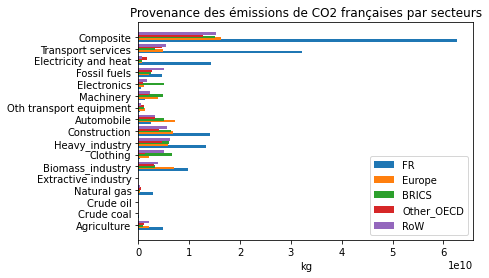

In [6]:
# save reference data base
reference.save_all(
	output_dir / ('reference' + '_' + concat_settings)   
)


# save conterfactural(s)
counterfactual.save_all(
	output_dir / ('counterfactual' + '_' + concat_settings)   
)


# concat results for visualisation
## ToDo
#print(reference.ghg_emissions_desag.D_cba.sum(axis=0).FR) #empreinte carbone totale (peut faire si gaz en kgCO2eq)
ghg_list = list(reference.ghg_emissions_desag.D_cba.index.get_level_values(1)[:7])
sectors_list=list(reference.get_sectors())
reg_list = list(reference.get_regions())

#for ghg in ghg_list:
#    with plt.style.context('ggplot'):
#        reference.ghg_emissions_desag.plot_account(ghg, figsize=(8,5))
#        plt.savefig('figures/ref_'+ghg+'.png', dpi=300)
#        plt.show()
ref_dcba = pd.DataFrame(reference.ghg_emissions_desag.D_cba)
filtre_co2 = ref_dcba.index.get_level_values(1)=='CO2'
CO2_total_by_sector = ref_dcba.iloc[filtre_co2]
print(CO2_total_by_sector)
width=0.7
fig,ax=plt.subplots()
position = [-6*width/5,-3*width/5,0,3*width/5,6*width/5]
rects=[]
x=3*np.arange(len(sectors_list))
for i in range(len(reg_list)):
	rects.append(ax.barh(x+position[i],np.array(CO2_total_by_sector['FR'].loc[reg_list[i]])[0],
	width,label=reg_list[i]))
ax.set_yticks(x)
ax.set_yticklabels(sectors_list)
ax.legend()
plt.xlabel("kg")
plt.title("Provenance des émissions de CO2 françaises par secteurs")
plt.show()

# VISUALIZE

In [21]:
ref_dcba.transpose()

region                                 FR                              \
stressor                              CO2           CH4           N2O   
region sector                                                           
FR     Agriculture           4.791573e+09  5.646409e+08  3.664735e+07   
       Crude coal            1.381993e+07  1.329030e+03  3.502939e+02   
       Crude oil             3.137212e+04  1.274021e+04  2.087866e+00   
       Natural gas           2.894399e+09  9.832002e+06  2.938855e+04   
       Extractive industry   5.813517e+06  1.287450e+04  4.747450e+02   
...                                   ...           ...           ...   
RoW    Electronics           5.623991e+08  3.141611e+06  1.428013e+05   
       Fossil fuels          4.301223e+08  2.118172e+06  4.800287e+04   
       Electricity and heat  5.186573e+07  8.531019e+05  4.699800e+04   
       Transport services    5.253624e+08  1.634175e+06  9.028361e+04   
       Composite             3.027342e+09  4.616336e+07  2.353707e+06   

region                                                                \
stressor                             SF6           HFC           PFC   
region sector                                                          
FR     Agriculture           1191.157833  1.486329e+09  8.921210e+06   
       Crude coal               0.119855  1.472910e+05  9.667250e+02   
       Crude oil                0.001104  1.468419e+03  1.256372e+01   
       Natural gas             20.263056  2.463284e+07  3.675394e+05   
       Extractive industry     20.413520  2.502661e+07  1.446679e+05   
...                                  ...           ...           ...   
RoW    Electronics             35.130340  4.378272e+07  6.014900e+05   
       Fossil fuels            33.218103  4.087367e+07  2.726443e+05   
       Electricity and heat     4.691098  5.776643e+06  5.593756e+04   
       Transport services      13.004593  1.565334e+07  1.651328e+05   
       Composite              293.792519  3.502999e+08  3.973688e+06   

region                             Europe                              \
stressor                              CO2           CH4           N2O   
region sector                                                           
FR     Agriculture           2.018949e+09  1.053125e+08  6.993633e+06   
       Crude coal            4.434783e+05  9.793169e+03  3.158740e+01   
       Crude oil             2.089283e+04  8.463915e+02  1.358002e+00   
       Natural gas           2.825042e+08  1.455883e+06  1.620015e+04   
       Extractive industry   4.997355e+06  1.163578e+04  3.413712e+02   
...                                   ...           ...           ...   
RoW    Electronics           5.297105e+09  2.304479e+07  5.759363e+05   
       Fossil fuels          5.647429e+09  3.309724e+07  2.525300e+05   
       Electricity and heat  5.872707e+08  4.240708e+06  1.106595e+05   
       Transport services    5.458653e+09  1.498003e+07  3.331338e+05   
       Composite             3.890126e+10  3.063632e+08  8.210771e+06   

region                                     ...    Other_OECD                \
stressor                              SF6  ...           N2O           SF6   
region sector                              ...                               
FR     Agriculture            3714.700496  ...  2.417947e+06    252.086860   
       Crude coal                1.794197  ...  1.137414e+02      0.999195   
       Crude oil                 0.009128  ...  3.846149e+00      0.019838   
       Natural gas             207.010404  ...  2.718494e+04     77.612393   
       Extractive industry      26.649637  ...  2.188063e+02      2.376334   
...                                   ...  ...           ...           ...   
RoW    Electronics            3826.053837  ...  2.725236e+06   4054.893872   
       Fossil fuels           3191.255594  ...  6.628847e+05   2615.159383   
       Electricity and heat    474.887228  ...  2.235057e+05    359.804193   
       Tr

['CO2', 'CH4', 'N2O', 'SF6', 'HFC', 'PFC']


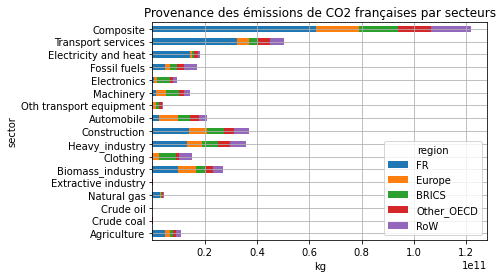

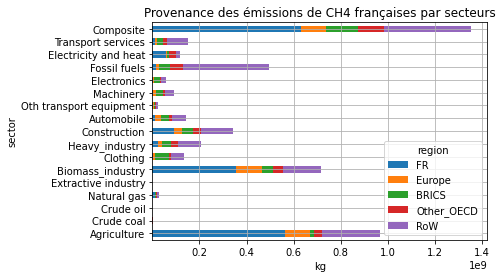

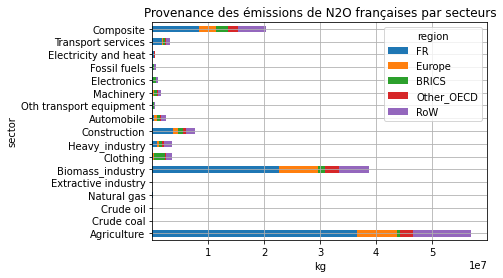

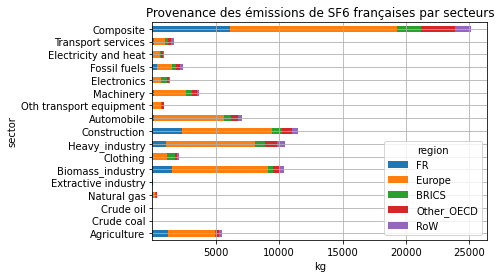

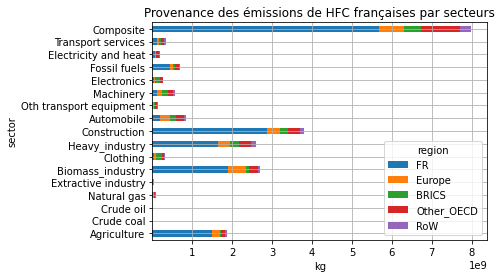

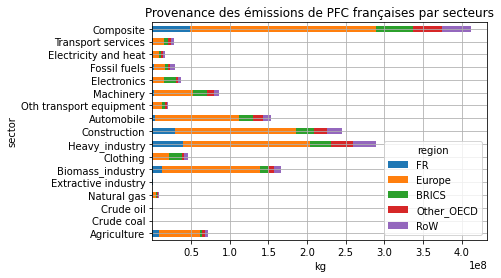

In [20]:
# reference analysis
## ToDo

ghg_list = list(reference.ghg_emissions_desag.D_cba.index.get_level_values(1)[:6])
print(ghg_list)
for ghg in ghg_list:
    df = pd.DataFrame(None, index = reference.get_sectors(), columns = reference.get_regions())
    for reg in reference.get_regions():
        df.loc[:,reg]=ref_dcba.transpose().loc['FR',(reg,ghg)]
    ax=df.plot.barh(stacked=True)
    plt.grid()
    plt.xlabel("kg")
    plt.title("Provenance des émissions de "+ghg+" françaises par secteurs")
    plt.savefig('figures/)
    plt.show()
# whole static comparative analysis
## ToDo